# 2 特征提取

In [1]:
import re
import os
import time
import csv
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import myUtils

### 2.0 参数设置、拟合函数

In [2]:
# 常数定义
CONST_PARAMS_DICT = {
    'frequency': 1 / 200, # 频率
    'U_amplitude': 421 / np.sqrt(3) * np.sqrt(2), #424,电压幅值
    'I_amplitude': 228,  # 电流幅值
    'U_eps': 5, # 可视为电压为0的阈值
    'I_eps': 5, # 可视为电流为0的阈值
    'three_phase': ['A','B','C']  # 三相名称
}

#### 拟合正弦函数

In [3]:
from scipy.optimize import leastsq
import warnings

def calSinByParams(x, params):
    '''
    根据x和参数输出sin函数值
    Args:
        x: x轴数据
        params: 参数
        
    Returns:
        对应的正弦值
    '''
    A, f, theta_x, theta_y = params 
    return A * np.sin(2 * np.pi * f * x + theta_x) + theta_y

def calFittingResidual(params, x, y_real):
    '''
    计算原始数据与拟合数据残差
    '''
    return y_real - calSinByParams(x, params)

def getOptFittingParams(data):
    '''
    获得拟合正弦曲线的最佳参数
    
    Args:
        data:待拟合的原始数据
        
    Returns:
        params_opt: 对原始数据进行正弦拟合的最佳参数
            params_opt[0]: A 振幅
            params_opt[1]: f 频率
            params_opt[2]: theta_x x轴方向上偏移
            params_opt[3]: theta_y y轴方向上的偏移
    '''

    # 待拟合数据
    X = np.arange(len(data))
    Y = np.array(data)
    
    # 初始化参数
    Y_sorted = sorted(Y)
    n = min(int(len(Y)/100), 10)
    A = (np.mean(Y_sorted[-n:]) - np.mean(Y_sorted[:n])) / 2
    
    
    # params_init:根据数据初始化拟合参数 
    params_init = [A, CONST_PARAMS_DICT['frequency'], 0, 0]
    
    # 最小二乘得到拟合最优解
    with warnings.catch_warnings():
        try:
            params_opt, _ = leastsq(calFittingResidual, params_init, args = (X, Y), maxfev=5000)
        except Warning as e:
            print(e)
            params_opt = params_init
    
    return params_opt

### 2.1 数据分段

#### 1) 计算燃弧范围

In [4]:
def findArcingRange(U_data, I_data):
    """
    计算燃弧区间
    
    Args:
        U_data: 单次操作的电压数据
        I_data: 单次操作的电流数据
    
    Returns:
        arcing_range: 
            arcing_range[0] = arcing_start 燃弧开始位置
            arcing_range[1] = arcing_end   燃弧结束位置
    """
    
    # 0. 初始化燃弧范围
    arcing_range = [-1, -1]
    
    n_points = 10
    data_len = len(U_data)
    
    # 1.确定燃弧结束位置：电流为0时表示燃弧结束（结束点后n_points对应的电流均小于电流阈值，结束点前n_points对应的电流均大于电流阈值）
    for i in range(data_len - n_points - 1, n_points, -1):
        #判断条件一、在[i - n_points,i]时刻内的电流是否大于0  
        n_Ii_larger_than_0 = 0
        for Ii in I_data[i - n_points : i]:
            if np.abs(Ii) > CONST_PARAMS_DICT['I_eps']:
                n_Ii_larger_than_0 += 1
        
        #判断条件二、在[i + 1, i + n_points]时刻内的电流是否接近0
        n_Ii_equals_0 = 0
        for Ii in I_data[i + 1: i + n_points]:
            if np.abs(Ii) < CONST_PARAMS_DICT['I_eps']:
                n_Ii_equals_0 += 1
        
        #若以上两个条件基本满足，则说明找到燃弧结束位置
        if n_Ii_larger_than_0 > n_points - 3 and n_Ii_equals_0 > n_points - 3:
            arcing_range[1] = i
            break
        
        
    # 2.确定燃弧开始位置
    
    # 方式一、根据残差确定燃弧开始位置，稳态时残差较小，而燃弧时残差较大
    # 截取部分合闸稳态数据，拟合得到稳态时的电压正弦波形
    end_loc = arcing_range[1] - int(1 / CONST_PARAMS_DICT['frequency'] * 5)
    start_loc = end_loc - int(1 / CONST_PARAMS_DICT['frequency'] * 3)
    U_part = np.array(U_data[start_loc : end_loc])
    params_U_close = getOptFittingParams(U_part)
    
    # 计算拟合的电压与原始数据的残差
    U_real = np.array(U_data[start_loc : arcing_range[1]])
    U_pred = calSinByParams(np.arange(len(U_real)), params_U_close)
    U_residual = np.abs(U_real - U_pred)
    
    # 判断在[i - n_points : i]时刻内的电压残差是否接近0
    # 从燃弧结束点开始往前遍历，如果当前点i的电压残差接近0，且[i - n_points : i]区间内的电压残差基本小于0，则找到燃弧起始点i
    arcing_range[0] = arcing_range[1]
    for i in range(len(U_residual) - 1, n_points - 1, -1):
        if U_residual[i] < CONST_PARAMS_DICT['U_eps']:
            n_U_residual_equals_0 = 0
            for u_residual in U_residual[i - n_points : i]:
                if u_residual < CONST_PARAMS_DICT['U_eps']:
                    n_U_residual_equals_0 += 1
             
            if n_U_residual_equals_0 > n_points -3:
                arcing_range[0] = start_loc + i
                break
            
            
    ''' 
    # 方式二、根据实际电压是否超过阈值判断
    for i in range(arcing_range[1], n_points, -1):
        if np.abs(U_data[i]) <= np.abs(params_U_close[0]):#CONST_PARAMS_DICT['U_eps']:
            # 判断条件一、在[i-n_point, i]时刻内的电压是否都小于电压阈值
            n_Ui_equals_0 = 0
            for Ui in U_data[i - n_points : i]:
                if np.abs(Ui) <= np.abs(params_U_close[0]):#< CONST_PARAMS_DICT['U_eps']:
                    n_Ui_equals_0 += 1
             
            if n_Ui_equals_0 > n_points / 2:
                arcing_range[0] = i
                break
    '''          
    return arcing_range

##### 单元测试

4 186


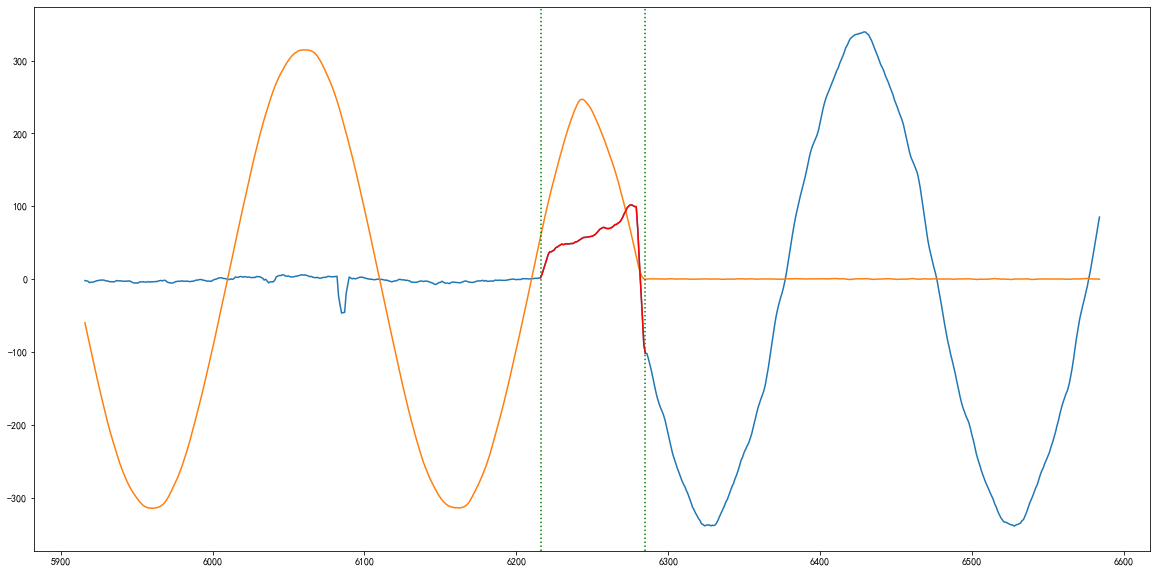

In [6]:
src_data_path = '../data/1_processed_data/2_smoothed_data/'
for machine_id in ['4']:
    operation_data_list = myUtils.loadPickleFile(src_data_path + machine_id + '.pkl')
    print(machine_id, len(operation_data_list))
    
    for op_idx in range(len(operation_data_list)):
        machine_df = operation_data_list[op_idx]
        U_data = machine_df['UA']
        I_data = machine_df['IA']
        arcing_range = findArcingRange(U_data, I_data)
        data_range = np.arange(arcing_range[0], arcing_range[1] + 1)
        show_data_range = np.arange(arcing_range[0] - 300, arcing_range[1] + 300)
        plt.figure(figsize=(20,10))
        plt.plot(U_data[show_data_range])
        plt.plot(I_data[show_data_range])
        plt.plot(U_data[data_range],'r')
        plt.axvline(arcing_range[0], c = 'g', ls = ':')
        plt.axvline(arcing_range[1], c = 'g', ls = ':')
        break

#### 2) 燃弧相角计算区间

In [5]:
def findPhaseAngleRange(U_data, arcing_range):
    """
    燃弧相角计算区间
    
    Args:
        U_data: 单次操作的电压数据
        arcing_range: 
            arcing_range[0] = arcing_start 燃弧开始位置
            arcing_range[1] = arcing_end   燃弧结束位置
            
    Returns:
        phase_angle_range:
            phase_angle_range[0]: 燃弧相角计算的起始位置
            phase_angle_range[1]: 燃弧相角计算的终止位置
    """
    
    n_points = 10
    data_len = len(U_data)
    
    # 燃弧区间异常判断
    if arcing_range[1]  == -1:
        print('Error: arcing range')
        return arcing_range
    
    # 1) 燃弧相角计算的起始位置：与燃弧的起始范围一致 
    phase_angle_range = [arcing_range[0], arcing_range[1]]
    
    # 2) 确定燃弧相角计算的结束点：电压从零开始上升的位置
    # 如果当前点i的电压小于等于0，且[i + 1, i + n_points]区间内的电压大于0，则找到结束点i
    for i in range(arcing_range[1] , data_len):
        n_Ui_larger_0 = 0
        if U_data[i] <= 0:
            for Ui in U_data[i + 1: i + n_points]:
                if Ui > 0:
                    n_Ui_larger_0 += 1
            
            if n_Ui_larger_0 >= n_points - 1:
                phase_angle_range[1] = i
                break
    return phase_angle_range

### 2.2 分阶段特征生成

#### 1) 燃弧特征提取
计算单次操作中的燃弧相角、时长、能量、电量、功率
- 燃弧相角：
- 燃弧时长(arcing_duration)：$t$ 
- 燃弧能量(arcing_energy)：$E = \int |i(t)u(t)|dt$
- 燃弧电量(arcing_electricity)：$\int i(t)^2dt$
- 燃弧功率(arcing_power)：$E / t$

In [8]:
def createArcingRangeDF(U_data, I_data):
    """
    计算燃弧区间
    
    Args:
        U_data: 单相电压数据
        I_data: 单相电流数据
    
    Returns:
        关于燃弧区间的特征(DataFrame)，包含以下几列：
            1. arcing_start: 燃弧起始点
            2. arcing_end: 燃弧终止点
            3. phase_angle_start: 燃弧相角计算起始点
            4. phase_angle_end: 燃弧相角计算终止点
    """
    
    arcing_range_cols = ['arcing_start', 'arcing_end', 'phase_angle_start', 'phase_angle_end']
    
    # 燃弧区间
    arcing_range = findArcingRange(U_data, I_data)
    
    if arcing_range[1] == -1:
        return pd.DataFrame([np.zeros(len(arcing_range_cols))], columns = arcing_range_cols)
        
    # 燃弧相角计算区间
    phase_angle_range = findPhaseAngleRange(U_data, arcing_range)
    
    arcing_range_df = pd.DataFrame([arcing_range + phase_angle_range], columns = arcing_range_cols)
    return arcing_range_df

In [9]:
createArcingRangeDF(U_data, I_data)

,arcing_start,arcing_end,phase_angle_start,phase_angle_end
0,6216,6285,6216,6377


In [ ]:
# 计算燃弧相角
def createArcingPhaseAngleDF(U_data, phase_angle_range = []):
    """
    计算燃弧相角
    
    Args:
        U_data:电压数据
        arcing_range:燃弧范围
            arcing_range[0]:燃弧起始点
            arcing_range[1]:燃弧结束点
    
    Returns:
        关于燃弧相角（电压）的特征(DataFrame)，包含以下几列：
            1. phase_angle_degree: 燃弧相角的角度值
            2. phase_angle_radian: 燃弧相角的弧度值
    """
    
    if phase_angle_range == []:
        phase_angle_range = findPhaseAngleRange(U_data, arcing_range)
    
    phase_angle_ftr_cols = ['phase_angle_degree', 'phase_angle_radian']
    
    if phase_angle_range[1] == -1:
        return pd.DataFrame([[-1, -1]], columns = phase_angle_ftr_cols)
    # 计算燃弧相角
    period = int(1/ CONST_PARAMS_DICT['frequency']) #周期
    # 将燃弧相角限定在0-360范围内？？？
    #if phase_angle_range[1] - phase_angle_range[0] > period:
    #    print('====large===')
    phase_angle = max(0, min(1 - (phase_angle_range[1] - phase_angle_range[0]) % period / period, 1))
    #print(phase_angle)
    phase_angle_degree = 360 * phase_angle       # 角度值
    phase_angle_radian = 2 * np.pi * phase_angle # 弧度值
    
    return pd.DataFrame([[phase_angle_degree, phase_angle_radian]], columns = phase_angle_ftr_cols)

In [31]:
def createArcingFeatureDF(U_data, I_data, arcing_range_df = pd.DataFrame()):
    """
    计算燃弧特征
    
    Args:
        U_data: 单相电压数据
        I_data: 单相电流数据
    
    Returns:
        关于燃弧阶段的特征(DataFrame)，包含以下几列：
            1. arcing_start: 燃弧起始点
            2. arcing_end: 燃弧终止点
            3. phase_angle_start: 燃弧相角计算起始点
            4. phase_angle_end: 燃弧相角计算终止点
            
            5. arcing_duration: 燃弧时长
            6. arcing_energy: 燃弧能量
            7. arcing_electricity: 燃弧电量
            8. arcing_power: 燃弧功率
            
            9. phase_angle_degree: 燃弧相角的角度值
            10. phase_angle_radian: 燃弧相角的弧度值
    """
    
    if arcing_range_df.empty:
        arcing_range_df = createArcingRangeDF(U_data, I_data)
    
    # 获得燃弧范围
    arcing_range = [arcing_range_df.loc[0]['arcing_start'], arcing_range_df.loc[0]['arcing_end']]
    
    # 1. 燃弧时长
    arcing_duration = max(0, arcing_range[1] - arcing_range[0])
    if arcing_duration > 2000:
        print('duration>2000')
        arcing_duration = 0
    if arcing_range[1] == -1:
        print(arcing_range)
    
    
    
    U_arcing = np.array(U_data[arcing_range[0] : arcing_range[1]])
    I_arcing = np.array(I_data[arcing_range[0] : arcing_range[1]])
    
    # 2. 燃弧阶段的经验特征（燃弧能量、电量、功率等）
    if arcing_duration <= 0:
        arcing_energy = 0
        arcing_electricity = 0
        arcing_power = 0
    else:
        # 燃弧能量
        arcing_energy = np.sum([np.abs(U_arcing[i] * I_arcing[i]) for i in range(arcing_duration)]) * 1e-3

        # 燃弧电量
        arcing_electricity = np.sum([I_arcing[i] ** 2 for i in range(arcing_duration)]) * 1e-3

        # 燃弧功率
        arcing_power = arcing_energy / arcing_duration
    
    arcing_ftr_df = pd.DataFrame([[arcing_duration, arcing_energy, arcing_electricity, arcing_power]], 
                             columns = ['arcing_duration', 'arcing_energy', 'arcing_electricity', 'arcing_power'])
    
    
    # 3. 燃弧相角
    phase_angle_range = [arcing_range_df.loc[0]['phase_angle_start'], arcing_range_df.loc[0]['phase_angle_end']]
    phase_angle_ftr_df = createArcingPhaseAngleDF(U_data, phase_angle_range)
    
    
    # 整合燃弧特征
    arcing_df = pd.concat([arcing_range_df, arcing_ftr_df, phase_angle_ftr_df], axis = 1)
    return arcing_df

#### 2) 合闸稳态特征生成

In [11]:
def extractTouchFeatures(U_data, I_data):
    """
    提取合闸后稳态特征
    
    Args:
        U_data: 单相电压数据
        I_data: 单相电流数据
    
    Returns:
        关于合闸稳态的特征(DataFrame)，包含以下几列：
            1. touch_U: 接触电压
            2. touch_I: 接触电流
            3. touch_R: 接触电阻
    """
    # 设置波形截取的起止位置
    end_loc = 6000 - int(1 / CONST_PARAMS_DICT['frequency'] * 2)
    start_loc = end_loc - int(1 / CONST_PARAMS_DICT['frequency'] * 5)
    
    # 获取接触时的电流、电压波形
    U_part = np.array(U_data[start_loc : end_loc])
    I_part = np.array(I_data[start_loc : end_loc])
    
    #plt.plot(U_data)
    #plt.plot(I_data)
    #plt.plot(np.arange(start_loc, end_loc), U_part)
    
    #拟合波形，得到接触电流、接触电压、接触电阻
    U_params = getOptFittingParams(U_part)
    I_params = getOptFittingParams(I_part)
    
    return pd.DataFrame([[np.abs(U_params[0]), np.abs(I_params[0]), np.abs(U_params[0] / (I_params[0] + 0.01))]], columns = ['touch_U', 'touch_I', 'touch_R'])

### 2.3 非波形特征整合

In [33]:
# 提取单相特征
def extract1PhaseFeatures(U_data, I_data, operation_stage = 'total'):
    """
    提取单相特征
    
    Args:
        U_data: 单次操作的单相电压数据(DataFrame)
        I_data: 单次操作的单相电流数据(DataFrame)
        operation_stage: 指定所要提取特征的操作阶段。
            可取值有：
                1. 'total': 表示提取所有阶段的特征（默认）
                2. 'arcing': 表示提取燃弧阶段特征
                3. 'touch': 表示提取合闸稳态阶段特征
    
    Returns:
        单相特征数据(DataFrame)
    """
    if operation_stage == 'arcing':
        return createArcingFeatureDF(U_data, I_data)
    elif operation_stage == 'touch':
        return extractTouchFeatures(U_data, I_data)
    else:
        arcing_df = createArcingFeatureDF(U_data, I_data)
        touch_df = extractTouchFeatures(U_data, I_data)
        return pd.concat([arcing_df, touch_df], axis = 1, sort = False)

# 提取三相特征
def extract3phaseFeatures(operation_data_list, operation_stage = 'total'):
    """
    提取三相特征
    
    Args:
        operation_data_list: 单个设备历次操作的数据列表(list)
            operation_data_list[i]: 设备第i次操作的波形数据(DataFrame)
            
        operation_stage: 指定所要提取特征的操作阶段。
            可取值有：
            1. 'total': 表示提取所有阶段的特征（默认）
            2. 'arcing': 表示提取燃弧阶段特征
            3. 'touch': 表示提取合闸稳态阶段特征
    
    Returns:
        三相特征数据(DataFrame)
    """
    machine_ftr_df = pd.DataFrame()
    for i, operation_data_list in enumerate(operation_data_list):
        
        operation_ftr_df = pd.DataFrame()
        for phase in CONST_PARAMS_DICT['three_phase']:
            #print(i,phase)
            U_data = operation_data_list['U' + phase]
            I_data = operation_data_list['I' + phase]
            cur_ftr_df = extract1PhaseFeatures(U_data, I_data, operation_stage)
            
            # 指定列名为某相的列名
            cur_ftr_cols = [phase + '_' + col for col in cur_ftr_df.columns.tolist()]
            cur_ftr_df.columns = cur_ftr_cols
            
            operation_ftr_df = pd.concat([operation_ftr_df, cur_ftr_df], axis = 1, sort = False)
        
        if i % 100 == 0:
            print(i)
        machine_ftr_df = machine_ftr_df.append(operation_ftr_df, ignore_index = True)
        #print(machine_ftr_df.columns)
    return machine_ftr_df

#### 提取并保存特征

In [6]:
root_data_path = '../data/'
processed_data_path = root_data_path + '1_processed_data/'
src_data_path = processed_data_path + '2_smoothed_data/'
src_machine_files =os.listdir(src_data_path)
print(src_machine_files)
feature_path = root_data_path + '2_features/'
myUtils.makedirs(feature_path)

['1.pkl', '10.pkl', '2.pkl', '3.pkl', '4.pkl', '5.pkl', '6.pkl', '7.pkl', '8.pkl', '9.pkl']
../data/2_features/ already exist.


In [7]:
myUtils.getMachineIds()

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [34]:
machine_ids = myUtils.getMachineIds()
for machine_id in machine_ids:
    t_start = time.time()
    operation_data_list = myUtils.loadPickleFile(src_data_path + machine_id + '.pkl')
    print(machine_id, len(operation_data_list))
    
    operation_stage = 'arcing' # 燃弧阶段
    #operation_stage = 'touch'  # 合闸稳态阶段
    #operation_stage = 'total'  # 所有阶段
    op_stage_path = root_data_path + '2_features/' + operation_stage + '/'
    myUtils.makedirs(op_stage_path)
    machine_ftr_df = extract3phaseFeatures(operation_data_list, operation_stage)
    #print(machine_ftr_df.head())
    machine_ftr_df.to_csv(op_stage_path + machine_id + '.csv', index = False, header = True)
    
    t_end = time.time()
    print('用时：', (t_end - t_start))

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
6 2159
../data/2_features/arcing/ already exist.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
用时： 2633.0576009750366
7 4522
../data/2_features/arcing/ already exist.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
用时： 5156.3670535087585
8 1622
../data/2_features/arcing/ already exist.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
用时： 1892.5232887268066
9 1393
../data/2_features/arcing/ already exist.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
用时： 1560.9381175041199
10 1650
../data/2_features/arcing/ already exist.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
用时： 1857.2126200199127


### 2.4 可视化（燃弧时段电压电流波形、燃弧起止位置、燃弧相角计算的起止位置）

In [8]:
root_fig_path = '../fig/'
tmp_fig_path = root_fig_path + '2_feature_extraction/arcing_range/'
myUtils.makedirs(tmp_fig_path)

../fig/2_feature_extraction/arcing_range/ already exist.


In [9]:
#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

4 186
../fig/2_feature_extraction/arcing_range/4#three_phase_waves/ already exist.


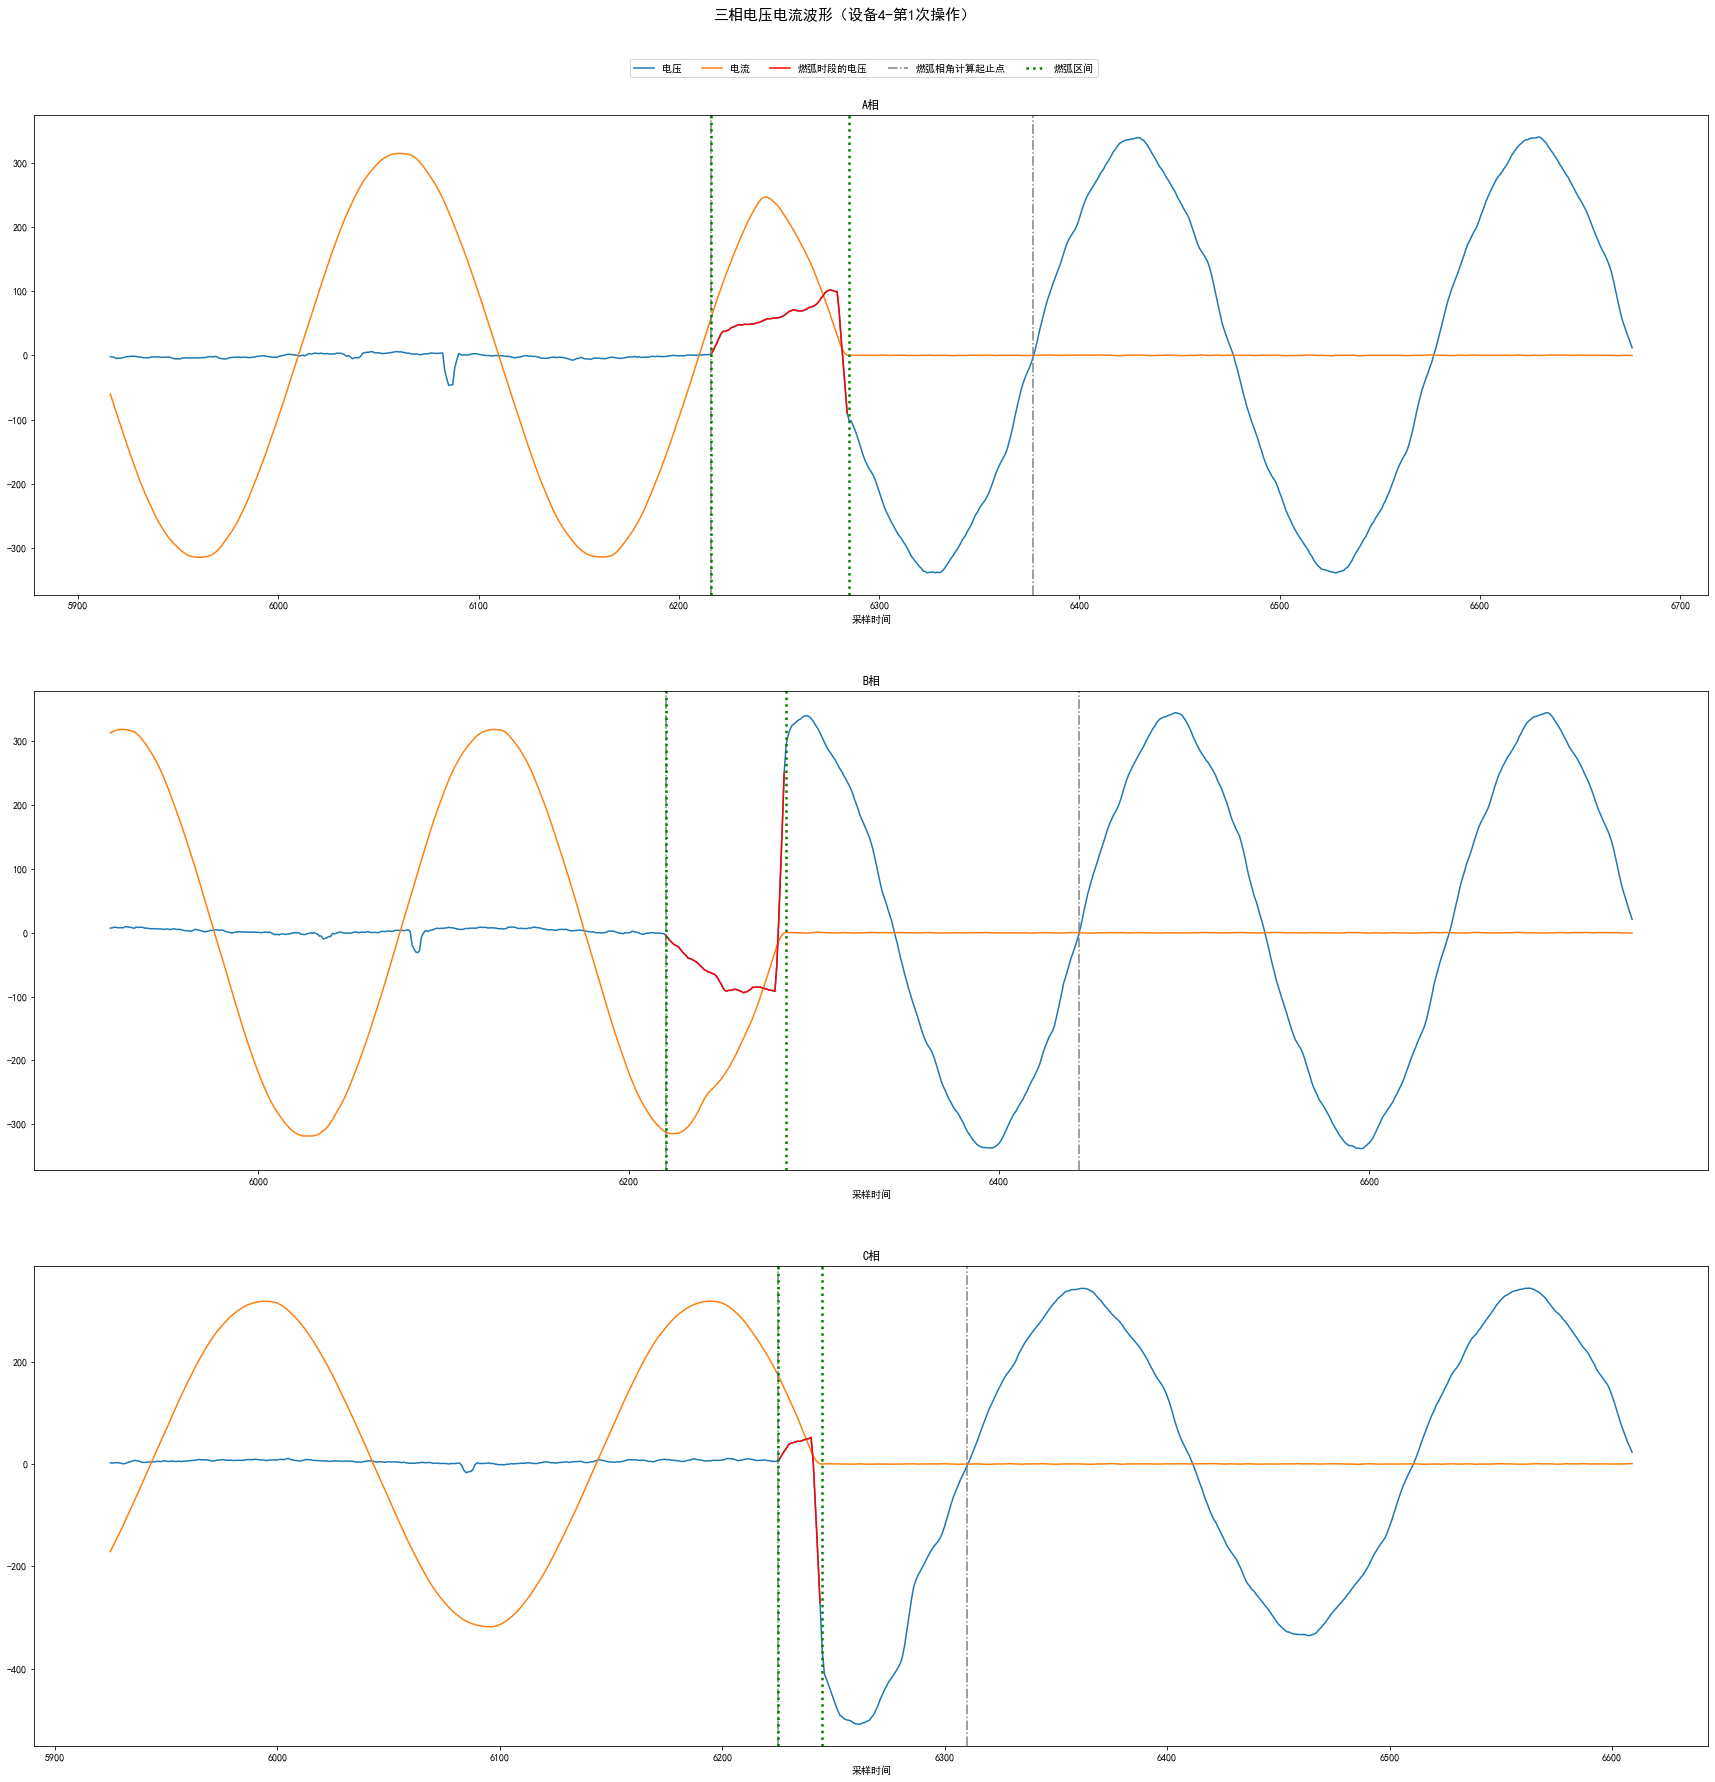

In [12]:
for machine_id in ['4']:
    operation_data_list = myUtils.loadPickleFile(src_data_path + machine_id + '.pkl')
    print(machine_id, len(operation_data_list))
    
    cur_phase_folder = tmp_fig_path + machine_id + '#three_phase_waves/'
    myUtils.makedirs(cur_phase_folder)
    
    for i in range(len(operation_data_list)):
        if i >= 10:
            break
        
        fig = plt.figure(figsize=(30,30))
        title = '三相电压电流波形（设备'+ machine_id +'-第'+ str(i + 1) + '次操作）'
        plt.suptitle(title, fontsize = 15, y = 0.93)
        for phase_idx, phase in enumerate(CONST_PARAMS_DICT['three_phase']):
            plt.subplot(3, 1, phase_idx + 1)
            U_data = operation_data_list[i]['U' + phase]
            I_data = operation_data_list[i]['I' + phase]
            
            arcing_range = findArcingRange(U_data, I_data)
            arcing_phase_range = findPhaseAngleRange(U_data, arcing_range)
            
            enlarge_range = 300
            show_data_range = np.arange(arcing_phase_range[0] - enlarge_range, arcing_phase_range[1] + enlarge_range)
            
            data_range = np.arange(arcing_range[0], arcing_range[1])
            plt.plot(U_data[show_data_range])
            plt.plot(I_data[show_data_range])
            plt.plot(U_data[data_range], 'r')
            plt.axvline(arcing_phase_range[0], c = 'gray', ls = '-.')
            plt.axvline(arcing_range[0], c = 'g', ls = ':', lw=2.5)
            plt.axvline(arcing_phase_range[1], c = 'gray', ls = '-.')
            plt.axvline(arcing_range[1], c = 'g', ls = ':',lw = 2.5)
            plt.title(phase + '相')
            plt.xlabel('采样时间')
        fig.legend(['电压','电流','燃弧时段的电压','燃弧相角计算起止点','燃弧区间'], loc = 'upper center', ncol=5, bbox_to_anchor=(0.25,0.8, 0.3, 0))
        plt.savefig(cur_phase_folder + 'op#' + str(i + 1) + '.png', dpi=100, bbox_inches ='tight' )
        if i == 0:
            plt.show()
        plt.close(fig)
        #plt.close(fig)
        #break